In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

from bs4 import BeautifulSoup

from __future__ import print_function
from scipy import stats
import statsmodels.api as sm


In [7]:
url = 'https://www.cleartrip.com/trains/results?from_station=CNB&to_station=NDLS&class=CC&date=28-1-2017&adults=1&children=0&male_seniors=0&female_seniors=0'
proxies = {
    'http': 'http://ironport2.iitk.ac.in:3128',
    'https': 'http://ironport2.iitk.ac.in:3128',
}
r = requests.get(url, verify=False, proxies=proxies)
soup = BeautifulSoup(r.text, 'lxml')
# print(soup)

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:794: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.org/en/latest/security.html
  InsecureRequestWarning)


In [26]:
fd = open('cleartrip_dat', 'w')
fd.write(str(soup))
fd.close()
# table = soup.find_all(class_='table datatable table-striped table-bordered')
table = soup.find_all('script', {'type' : 'text/javascript'})
print(table)

[<script type="text/javascript">
  var trackUserId = '';
</script>, <script type="text/javascript">
Event.observe(window, "load", function() {
	var viewPort = document.viewport.getDimensions();
	if($$(".cHeight")[0]){
		$$(".cHeight")[0].style.height = viewPort.height - ($("GlobalNav").getHeight() +  $$(".globalFooter")[0].getHeight()) +"px"
	}
	  
	if($$(".rHeight")[0]){
		$$(".rHeight")[0].style.minHeight = viewPort.height - ($("GlobalNav").getHeight() +  $$(".primaryBar")[0].getHeight() + $$(".globalFooter")[0].getHeight()) +"px"
	}
	
	if($$(".calHeight")[0]){
		$$(".calHeight")[0].style.minHeight = viewPort.height +"px"
	}
	  
	if($$(".acrHeight")[0]){
		$$(".acrHeight")[0].style.minHeight = viewPort.height - ($("GlobalNav").getHeight() +  $$(".globalFooter")[0].getHeight()) +"px"
	}
});
  
	
</script>, <script src="http://www.cleartrip.com/offermgmt/B2CTrainSearch_IN.js?01272017" type="text/javascript"></script>, <script type="text/javascript">
  var trainData = {"trains":{"1":{"n

In [73]:
date = []
delay = []
for row in table[0]('tr')[1:]:
    col = row('td')
    date.append(col[0].string)
    delay.append(col[2].string)


In [74]:
dtime = []
for time in delay:
    if time.find('Hr') != -1:
        dtime.append(60*int(time[0:time.find('Hr')]) + int(time[time.find('Hr')+3:time.find('Min')]))
    elif time.find('Min') != -1:
        dtime.append(int(time[0:time.find('Min')]))
    else:
        dtime.append(0)


In [75]:
R = 0.3
smoothed_dtime = [0]*len(dtime)
smoothed_dtime[0] = dtime[0]
for t in range(1,len(dtime)):
    smoothed_dtime[t] = R*dtime[t] + (1-R)*smoothed_dtime[t-1]
plt.plot(smoothed_dtime)
plt.xlabel('Days of year')
plt.ylabel('Delay in mins')

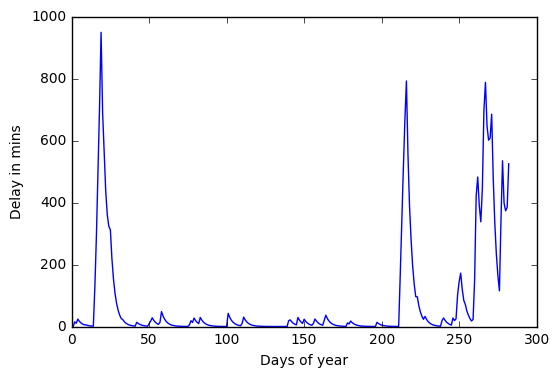

In [76]:
plt.show()

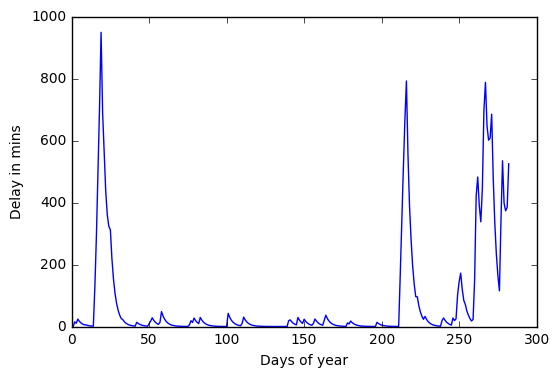

In [77]:
plt.plot(smoothed_dtime[0:300])
plt.xlabel('Days of year')
plt.ylabel('Delay in mins')
plt.show()

In [78]:

rng = pd.date_range('1/1/2016', periods=len(smoothed_dtime), freq='D')
print(rng)

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2016-09-30', '2016-10-01', '2016-10-02', '2016-10-03',
               '2016-10-04', '2016-10-05', '2016-10-06', '2016-10-07',
               '2016-10-08', '2016-10-09'],
              dtype='datetime64[ns]', length=283, freq='D')


In [79]:
df = pd.Series(smoothed_dtime, index=rng)
# df.to_csv('traindat.csv')

In [80]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=40, ax=ax2)

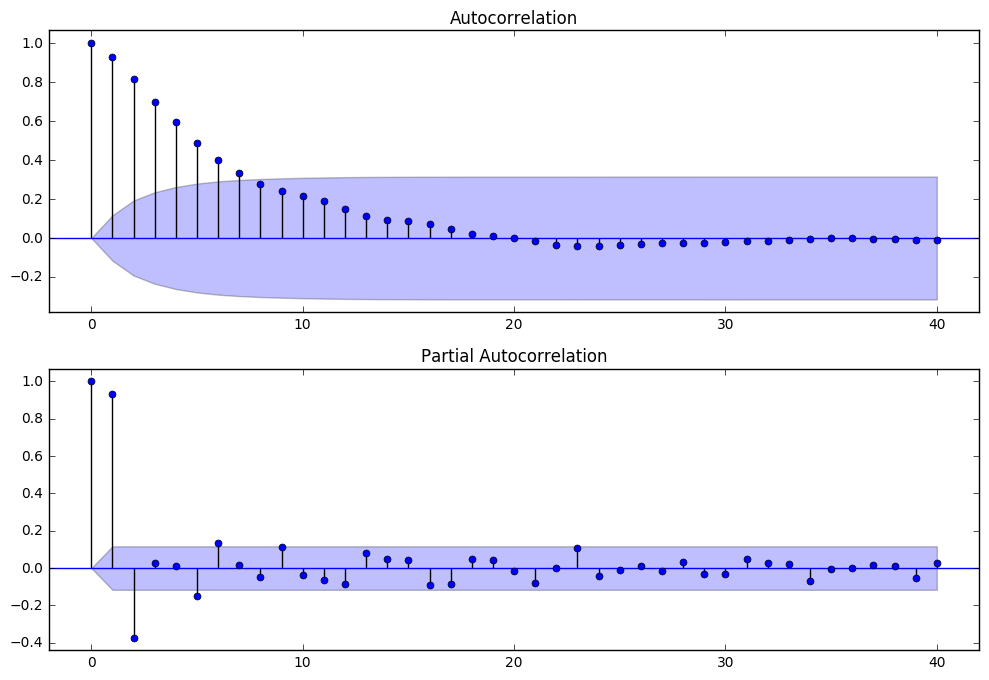

In [81]:
plt.show()

In [ ]:
from statsmodels.tsa import arima_model
arma_mod28 = sm.tsa.ARMA(df, (100,0)).fit()
print(arma_mod28.aic, arma_mod28.bic, arma_mod28.hqic)

In [ ]:
predict_delays = arma_mod28.predict('2016-04-29', '2016-06-30', dynamic=True)
fig, ax = plt.subplots(figsize=(12, 8))
ax = df.ix['2016-01-01':].plot(ax=ax)
fig = arma_mod28.plot_predict('2016-04-30', '2016-06-30', dynamic=True, ax=ax, plot_insample=False)
plt.xlabel('Date')
plt.ylabel('Delay')
plt.show()

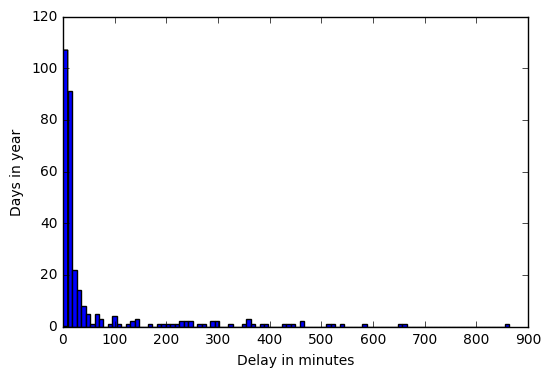

In [35]:
n,x,c = plt.hist(df, 100, normed=0)
plt.xlabel('Delay in minutes')
plt.ylabel('Days in year')
plt.show()

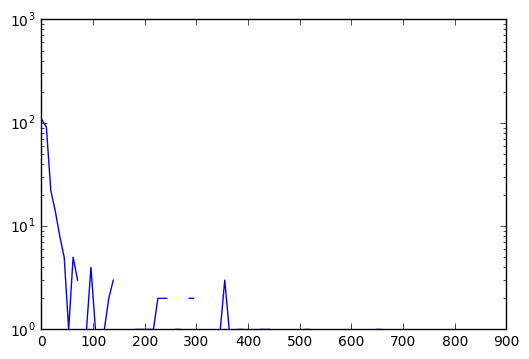

In [36]:
plt.semilogy(x[0:100],n)
plt.show()

In [37]:
def model(t, a, b):
   return a*np.exp(-b*t)

In [38]:
y = model(30, 2, 3)
y

1.6388025247981029e-39

In [39]:
from scipy.stats import expon
param = expon.fit(n)
param

(-3.113374741120943e-10, 3.0600695505249598)

In [40]:
plt.plot(x[0:100], expon.pdf(x[0:100], 0 , 4))
n,x,c = plt.hist(df, 100, normed=1)
plt.bar(x[0:100],n)
plt.xlabel('Delay')
plt.ylabel('Days')
plt.savefig('delay.png')